# 1. Set up

In [1]:
import os, time, copy, math, numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps")

In [3]:
SEED = 42
def set_seed(seed = SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [4]:
DATA_ROOT = "./data/cats_dogs"
IMG_SIZE = 224
BATCH_T = 64
BATCH_V = 128
NUM_WORKERS = 2
EPOCHS = 9

# 2. Data

In [10]:
import tensorflow as tf 
DATASET_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

zip_path = tf.keras.utils.get_file(
    fname="cats_and_dogs_filtered.zip",
    origin=DATASET_URL,
    extract=True,
    cache_dir=DATA_ROOT,          # 自定义根目录
)

68606236/68606236 [==============================] - 2s 0us/step


In [11]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), #resize to 224,224
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_dir = os.path.join(DATA_ROOT, "train")
val_dir = os.path.join(DATA_ROOT, "val")

train_set = datasets.ImageFolder(train_dir, transform=train_tfms)
val_set = datasets.ImageFolder(val_dir, transform=val_tfms)

num_classes = len(train_set.classes)
class_names = train_set.classes

print(f"Classes: {class_names}")

train_loader = DataLoader(train_set, batch_size=BATCH_T, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_V, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Classes: ['cats', 'dogs']


# 3. Models + Modes

PlainCNN/ResNet-18/DenseNet-121/VGG_16

In [12]:
def conv_bn_relu(cin, cout, k=3, s=1, p=1):
    return nn.Sequential(
        nn.Conv2d(cin, cout, kernel_size=k, stride=s, padding=p, bias=False),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
    )

In [14]:
class PlainCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2):
        super().__init__()
        self.enc = nn.Sequential(
            conv_bn_relu(in_ch, 32),
            nn.MaxPool2d(2),
            conv_bn_relu(32, 64),
            nn.MaxPool2d(2),
            conv_bn_relu(64, 128),
            nn.MaxPool2d(2),
            conv_bn_relu(128, 256),
            nn.MaxPool2d(2),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), #GLOABAL AVERAGE POOL no matter the input shape, out put N * 256 * 1 * 1
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

        #Kaiming init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.enc(x)
        x = self.head(x)
        return x

In [15]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

In [17]:
def _weights_or_none_resnet18(mode):
    if mode == "scratch":
        return None
    else:
        return models.ResNet18_Weights.IMAGENET1K_V1

In [21]:
def _weights_or_none_densenet121(mode):
    if mode == "scratch":
        return None
    else:
        return models.DenseNet121_Weights.IMAGENET1K_V1

In [19]:
def _weights_or_none_vgg16(mode):
    if mode == "scratch":
        return None
    else:
        return models.VGG16_Weights.IMAGENET1K_V1

In [20]:
def build_plaincnn(mode="scratch"):
    model = PlainCNN(num_classes=num_classes)
    return model.to(device), [{"params": model.parameters(), "lr":1e-3}]

In [22]:
def build_resnet18(mode="scratch"):
    w = _weights_or_none_resnet18(mode)
    model = models.resnet18(weights=w)
    in_feat = model.fc.in_features # last feature dimension
    model.fc = nn.Linear(in_feat, num_classes)

    params = []
    if mode == "scratch":
        for p in model.parameters():
            p.requires_grad = True
        params = [{"params": model.parameters(), "lr": 1e-3}]

    elif mode == "freeze":
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True
        params = [{"params": model.fc.parameters(), "lr": 3e-3}]

    elif mode == "finetune":
        for p in model.parameters(): p.requires_grad = False
        for p in model.layer4.parameters(): p.requires_grad = True  # unfreeze last stage / 解冻最后stage
        for p in model.fc.parameters():    p.requires_grad = True
        params = [
            {"params": model.layer4.parameters(), "lr": 5e-4},
            {"params": model.fc.parameters(),      "lr": 1e-3},
        ]
    return model.to(device), params

In [23]:
def build_densenet121(mode="scratch"):
    w = _weights_or_none_densenet121(mode)
    model = models.densenet121(weights=w)
    in_feat = model.classifier.in_features
    model.classifier = nn.Linear(in_feat, num_classes)

    if mode == "scratch":
        for p in model.parameters(): p.requires_grad = True
        params = [{"params": model.parameters(), "lr": 1e-3}]
    elif mode == "freeze":
        for p in model.parameters(): p.requires_grad = False
        for p in model.classifier.parameters(): p.requires_grad = True
        params = [{"params": model.classifier.parameters(), "lr": 3e-3}]
    elif mode == "finetune":
        for p in model.parameters(): p.requires_grad = False
        # Unfreeze last denseblock (features.denseblock4) / 解冻最后一个denseblock
        for p in model.features.denseblock4.parameters(): p.requires_grad = True
        for p in model.classifier.parameters():           p.requires_grad = True
        params = [
            {"params": model.features.denseblock4.parameters(), "lr": 5e-4},
            {"params": model.classifier.parameters(),           "lr": 1e-3},
        ]
    return model.to(device), params

In [24]:
def build_vgg16(mode="scratch"):
    w = _weights_or_none_vgg16(mode)
    model = models.vgg16(weights=w)
    in_feat = model.classifier[-1].in_features
    # Replace the final classifier layer (keep earlier FCs) / 仅替换最后一层分类器
    model.classifier[-1] = nn.Linear(in_feat, num_classes)

    if mode == "scratch":
        for p in model.parameters(): p.requires_grad = True
        params = [{"params": model.parameters(), "lr": 1e-3}]
    elif mode == "freeze":
        for p in model.features.parameters(): p.requires_grad = False # freeze conv backbone / 冻结卷积骨干
        for p in model.classifier.parameters(): p.requires_grad = True
        params = [{"params": model.classifier.parameters(), "lr": 1e-3}]
    elif mode == "finetune":
        # Typical finetune: unfreeze top conv block (features[24:]) + classifier / 解冻顶层卷积块+分类器
        for p in model.parameters(): p.requires_grad = False
        for p in model.features[24:].parameters(): p.requires_grad = True
        for p in model.classifier.parameters():    p.requires_grad = True
        params = [
            {"params": model.features[24:].parameters(), "lr": 5e-4},
            {"params": model.classifier.parameters(),     "lr": 1e-3},
        ]
    return model.to(device), params

In [25]:
BUILDERS = {
    "plaincnn":   build_plaincnn,
    "resnet18":   build_resnet18,
    "densenet121":build_densenet121,
    "vgg16":      build_vgg16,
}

# 4. Train and eval

In [26]:
def accuracy_from_logits(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()

In [27]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        bs = x.size(0)
        tot_loss += loss.item() * bs
        tot_acc  += accuracy_from_logits(out, y) * bs
        n += bs
    return tot_loss / n, tot_acc / n

In [28]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)  # clear grads / 清梯度
        out = model(x)
        loss = criterion(out, y)
        loss.backward()                        # backprop / 反向传播
        optimizer.step()                       # update / 更新参数
        bs = x.size(0)
        tot_loss += loss.item() * bs
        tot_acc  += accuracy_from_logits(out, y) * bs
        n += bs
    return tot_loss / n, tot_acc / n

# 5. Rund one model + one mode

In [33]:
def run_experiment(arch="resnet18", mode="freeze", epochs=EPOCHS, wd=1e-4):
    """
    arch: 'plaincnn' | 'resnet18' | 'densenet121' | 'vgg16'
    mode: 'scratch'  | 'freeze'   | 'finetune'
    """
    build = BUILDERS[arch]
    model, param_groups = build(mode)
    optimizer = torch.optim.AdamW(param_groups, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    t0 = time.time()
    for ep in range(1, epochs+1):
        trL, trA = train_one_epoch(model, train_loader, optimizer, criterion)
        vaL, vaA = evaluate(model, val_loader, criterion)
        hist["train_loss"].append(trL); hist["train_acc"].append(trA)
        hist["val_loss"].append(vaL);   hist["val_acc"].append(vaA)
        print(f"[{arch:10s}|{mode:8s}] ep{ep:02d} | train {trL:.4f}/{trA:.4f} | val {vaL:.4f}/{vaA:.4f}")
    dur = time.time() - t0
    params = count_params(model)
    print(f"=> {arch}|{mode}: params={params/1e6:.2f}M, time={dur:.1f}s")

    return model, hist, {"arch":arch, "mode":mode, "params":params, "time_sec":dur}

# 6. Plot

In [30]:
def plot_error_curves(hists, labels, title="Cats vs Dogs: Error vs Epoch"):
    # error = 1 - acc / 误差 = 1 - 准确率
    ep = range(1, len(hists[0]["val_acc"])+1)
    plt.figure(figsize=(9,6))
    for h, lab in zip(hists, labels):
        plt.plot(ep, 1 - np.array(h["train_acc"]), "--", label=f"{lab} train")
        plt.plot(ep, 1 - np.array(h["val_acc"]),   "-",  label=f"{lab} val")
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel("Error (1-acc)")
    plt.grid(True); plt.legend(); plt.show()

# 7. Run a compact suite

In [31]:
SUITE = [
    ("plaincnn", "scratch"),
    ("resnet18", "freeze"),
    ("resnet18", "finetune"),
    ("densenet121", "freeze"),
    ("vgg16", "freeze")
]

[plaincnn  |scratch ] ep01 | train 0.6768/0.6115 | val 0.6552/0.6080
[plaincnn  |scratch ] ep02 | train 0.6362/0.6265 | val 0.6790/0.5890
[plaincnn  |scratch ] ep03 | train 0.6176/0.6620 | val 0.6181/0.6660
[plaincnn  |scratch ] ep04 | train 0.6131/0.6690 | val 0.5836/0.7020
[plaincnn  |scratch ] ep05 | train 0.5869/0.6830 | val 0.5773/0.6890
[plaincnn  |scratch ] ep06 | train 0.5682/0.7080 | val 0.6512/0.6590
[plaincnn  |scratch ] ep07 | train 0.5607/0.7165 | val 0.6160/0.7060
[plaincnn  |scratch ] ep08 | train 0.5622/0.7090 | val 0.5508/0.7320
[plaincnn  |scratch ] ep09 | train 0.5431/0.7355 | val 0.5927/0.7130
=> plaincnn|scratch: params=0.39M, time=290.2s
[resnet18  |freeze  ] ep01 | train 0.2508/0.8915 | val 0.0856/0.9700
[resnet18  |freeze  ] ep02 | train 0.0993/0.9645 | val 0.0665/0.9780
[resnet18  |freeze  ] ep03 | train 0.0871/0.9680 | val 0.0784/0.9640
[resnet18  |freeze  ] ep04 | train 0.0913/0.9620 | val 0.0653/0.9770
[resnet18  |freeze  ] ep05 | train 0.0730/0.9730 | val 0

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/mamba/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|█| 30.8M/30.8M [00:00<00:00, 47.3MB


[densenet121|freeze  ] ep01 | train 0.2424/0.8970 | val 0.0809/0.9710
[densenet121|freeze  ] ep02 | train 0.0794/0.9715 | val 0.0436/0.9880
[densenet121|freeze  ] ep03 | train 0.0554/0.9815 | val 0.0361/0.9870
[densenet121|freeze  ] ep04 | train 0.0559/0.9790 | val 0.0329/0.9890
[densenet121|freeze  ] ep05 | train 0.0524/0.9815 | val 0.0354/0.9900
[densenet121|freeze  ] ep06 | train 0.0746/0.9715 | val 0.0433/0.9850
[densenet121|freeze  ] ep07 | train 0.0588/0.9775 | val 0.0445/0.9810
[densenet121|freeze  ] ep08 | train 0.0377/0.9880 | val 0.0270/0.9890
[densenet121|freeze  ] ep09 | train 0.0454/0.9840 | val 0.0297/0.9880
=> densenet121|freeze: params=6.96M, time=351.0s


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/mamba/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|█| 528M/528M [00:12<00:00, 43.9MB/s


[vgg16     |freeze  ] ep01 | train 0.5281/0.9275 | val 0.0503/0.9900
[vgg16     |freeze  ] ep02 | train 0.1996/0.9710 | val 0.1458/0.9900
[vgg16     |freeze  ] ep03 | train 0.1823/0.9840 | val 0.2018/0.9850
[vgg16     |freeze  ] ep04 | train 0.0735/0.9880 | val 0.1701/0.9820
[vgg16     |freeze  ] ep05 | train 0.1392/0.9880 | val 0.1888/0.9870
[vgg16     |freeze  ] ep06 | train 0.2243/0.9835 | val 0.3665/0.9810
[vgg16     |freeze  ] ep07 | train 0.1208/0.9910 | val 0.8091/0.9640
[vgg16     |freeze  ] ep08 | train 0.1481/0.9905 | val 0.6809/0.9870
[vgg16     |freeze  ] ep09 | train 0.3417/0.9850 | val 1.0312/0.9800
=> vgg16|freeze: params=134.27M, time=2526.0s


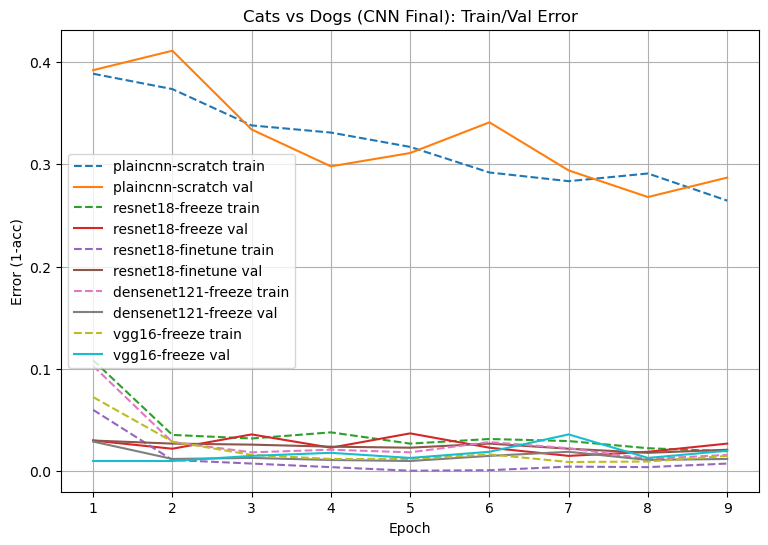


=== Summary (Params, Best Val Acc) ===
plaincnn     scratch   | params=  0.39M | best_val_acc=0.7320 | time=290.2s
resnet18     freeze    | params= 11.18M | best_val_acc=0.9850 | time=257.6s
resnet18     finetune  | params= 11.18M | best_val_acc=0.9820 | time=271.0s
densenet121  freeze    | params=  6.96M | best_val_acc=0.9900 | time=351.0s
vgg16        freeze    | params=134.27M | best_val_acc=0.9900 | time=2526.0s


In [34]:
hists, labels, infos = [], [], []
for (arch, mode) in SUITE:
    model, hist, info = run_experiment(arch=arch, mode=mode, epochs=EPOCHS)
    hists.append(hist)
    labels.append(f"{arch}-{mode}")
    infos.append(info)

plot_error_curves(hists, labels, title="Cats vs Dogs (CNN Final): Train/Val Error")

# Print summary table / 打印总结表
print("\n=== Summary (Params, Best Val Acc) ===")
for h, info in zip(hists, infos):
    best_val = max(h["val_acc"])
    print(f"{info['arch']:<12s} {info['mode']:<9s} | params={info['params']/1e6:>6.2f}M | best_val_acc={best_val:.4f} | time={info['time_sec']:.1f}s")